In [1]:
import re
import toml
import requests
import fasttext
import pandas as pd

from nltk import tokenize
from bs4 import BeautifulSoup
from os import listdir, getcwd
from tqdm.notebook import tqdm
from os.path import isfile, join

## 1. Clean existing data

In [2]:
def remove_md_links(input_str):
    re_detect = r'\[([\d\w\s]*)\]\(http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+\)'
    return re.sub(re_detect,r'\1', input_str)

def clean_toml_multiline(data_str):
    # identify """-sections
    split_list = data_str.split('"""')
    split_list = [elem.strip() for elem in split_list]
    if len(split_list) == 1:
        return split_list[0]
    else:
        # replace \n within """ """-blocks with \\n\\n
        output_content = []
        for idx, elem in enumerate(split_list):
            if idx%2!=0:
                elem = elem.replace("\n","\\n")
                elem = elem.replace('"',"'")
            output_content.append(elem)
        return '"'.join(output_content)

def clean_toml(filepath):
    with open(filepath, "r") as f:
        data_str = f.read()
        f.close
    data_str = remove_md_links(data_str)
    data_str = clean_toml_multiline(data_str)
    return data_str

def str_to_file(input_str, filepath):
    with open(filepath, "w") as f:
        f.write(input_str)
        f.close

In [ ]:
orig_toml_path = "/".join([getcwd(), "privacyspy/products/"])
orig_toml_files = [f for f in listdir(orig_toml_path) if (isfile(join(orig_toml_path, f))) and (".toml" in f)]

In [ ]:
for toml_file in tqdm(orig_toml_files):
    toml_clean_str = clean_toml("".join([orig_toml_path, toml_file]))
    file_path = "/".join([getcwd(), "data_rel/saved/privacyspy/clean_tomls",toml_file])
    str_to_file(toml_clean_str, file_path)

## 2. Bring clean data into proper format for further analysis

In [3]:
PRETRAINED_MODEL_PATH = './models/fasttext/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

def ft_guess_language(inpt):
    label,prec = model.predict(inpt)
    lang = label[0].split("__")[2]
    prec_f = prec[0]
    return lang, prec_f

In [4]:
def toml_to_df(toml_dict):
    service_name = toml_dict['name']
    sources = ", ".join(toml_dict['sources'])
    text_df = extract_citations(toml_dict['rubric'])
    text_df.insert(0, "sources", sources)
    text_df.insert(0, "service_name", service_name)
    return text_df

def extract_citations(rubric_dict):
    res_df = pd.DataFrame(columns=["text","tag","value","tagval","notes", "lang", "prec"])
    for key, val in rubric_dict.items():
        tag = key
        if 'citations' in val:
            value = val['value']
            tagval = "-".join([tag, value])
            notes = " ".join(val['notes']) if "notes" in val else ""   
            for citation in val['citations']:
                sent_list = split_into_clean_sentences(citation)
                for sentence in sent_list:
                    if len(sentence.split(" ")) > 3: # mehr als drei wörter
                        lang, prec = ft_guess_language(sentence)
                        new_row = {'text':sentence,'tag':tag,'value':value, 'tagval':tagval,'notes':notes,
                                   "lang":lang, "prec":prec}
                        res_df = res_df.append(new_row,ignore_index=True)
    return res_df

def split_into_clean_sentences(input_str) -> list:
    sent_list = tokenize.sent_tokenize(input_str)
    sent_list = [tkn.split("\n") for tkn in sent_list]
    sent_list = [tkn_list for sublist in sent_list for tkn_list in sublist]
    sent_list = [strip_nonalphanumeric(tkn.strip()).lower() for tkn in sent_list]
    return sent_list

def strip_nonalphanumeric(input_str):
    return re.sub(r"^\W+|\W+$", "", input_str)

In [ ]:
clean_toml_path = "/".join([getcwd(), "data_rel/saved/privacyspy/clean_tomls/"])
toml_files = [f for f in listdir(clean_toml_path) if (isfile(join(clean_toml_path, f))) and (".toml" in f)]

In [ ]:
all_dfs = pd.DataFrame(columns=["service_name", "sources", "text","tag","value","tagval","notes", "lang", "prec"])
for toml_file in tqdm(toml_files):
    #print("'{}'".format(toml_file))
    toml_dict = toml.load("".join([clean_toml_path, toml_file]))
    if "sources" in toml_dict: # only include examples where source can be traced
        rubric_df = toml_to_df(toml_dict)
        file_name = "".join([getcwd(),"/data_rel/saved/privacyspy/services/",
                             re.sub(".toml","",toml_file), ".csv"])
        rubric_df.to_csv(file_name, index=False, sep="\t")
        all_dfs = pd.concat([all_dfs, rubric_df])
all_dfs.to_csv("".join([getcwd(),"/data_rel/saved/privacyspy/privspy_all_points.csv"]), index=False, sep="\t")

## 3. Extract associated negative samples (and verify data)
### 3.1. Scrape data sources

In [1]:
path_all = "".join([getcwd(),"/data_rel/saved/privacyspy/privspy_all_points.csv"])
all_dfs = pd.read_csv(path_all, sep="\t")

NameError: name 'getcwd' is not defined

In [ ]:
sources = list(all_dfs.sources.unique())
all_sources = []
for elem in sources:
    split_elem = elem.split(", ")
    if len(split_elem) == 1:
        all_sources.append(split_elem[0])
    else:
        for sub_elem in split_elem:
            all_sources.append(sub_elem)

In [ ]:
all_sources = ["".join(["https://www.",source]) if "http" not in source else source for source in all_sources]

In [5]:
from selenium.webdriver import Firefox
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from time import sleep

In [6]:
def get_topics_from_html(topic_url):
    topic_soup = response_to_soup(topic_url)
    return topic_soup.find_all('a',title="View more details")

def get_source_soup(source_url):
    driver = Firefox()
    driver.get(source_url)
    source_soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.close()
    driver.quit()
    return source_soup

def remove_links(input_string):
    return re.sub(r"<.?link[^>]*>|<a[^>]*>", "", input_string)

def replace_html_tags(input_string, replacement):
    return re.sub('<[^>]*>', replacement, input_string)

def flatten(lst):
    return [elem for sublist in lst for elem in sublist]

def list_from_soup(bs_elem):
    body_string = str(bs_elem.find("body"))
    body_clean = remove_links(body_string)
    body_list = replace_html_tags(body_clean, "*--*").split("*--*")
    clean_list = [split_into_clean_sentences(elem) for elem in body_list if elem != ""]
    clean_list = flatten(clean_list)
    clean_list = [elem for elem in clean_list if elem]
    return clean_list

In [ ]:
res_df = pd.DataFrame(columns=["source", "text", "lang", "prec"])
for source in tqdm(all_sources):
    try:
        source_soup = get_source_soup(source)
        clean_list = list_from_soup(source_soup)
        for elem in clean_list:
            if len(elem.split(" ")) > 3:
                lang, prec = ft_guess_language(elem)
                new_row = {'source':source,'text':elem,"lang":lang, "prec":prec}
                res_df = res_df.append(new_row, ignore_index=True)
    except:
        new_row = {'source':source,'text':"ERROR","lang":"ERROR", "prec":"ERROR"}
        res_df = res_df.append(new_row, ignore_index=True)
    res_df.to_csv("".join([getcwd(),"/data_rel/saved/privacyspy/privspy_all_text.csv"]), index=False, sep="\t")

### 3.2. examine scraped data

quickcheck: how many of sentencs extracted from privacyspy.org are in associated scraped data set?

In [177]:
from matplotlib import pyplot as plt

In [107]:
all_points = pd.read_csv("".join([getcwd(),"/data_rel/saved/privacyspy/privspy_all_points.csv"]), sep= "\t")

In [105]:
all_text = pd.read_csv("".join([getcwd(),"/data_rel/saved/privacyspy/privspy_all_text.csv"]), sep="\t")

In [163]:
def check_in_scraped(row):
    all_sources = row['sources'].split(", ")
    rel_scraped = all_text[all_text.source.isin(all_sources)]
    text_list = rel_scraped['text'].to_list()
    return int(row['text'] in text_list)

In [164]:
all_points["in_scraped"] = all_points.apply(check_in_scraped, axis=1)

In [174]:
percs_contained = all_points.groupby(["service_name"]).agg(perc_in_scrape=('in_scraped', 'mean'),).value_counts()

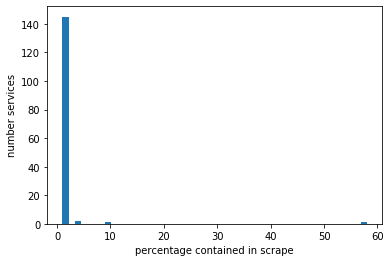

In [176]:
plt.hist(percs_contained, bins=50)
plt.xlabel('percentage contained in scrape')
plt.ylabel('number services')

plt.show()

more thorough cleanup

In [152]:
all_points

,service_name,sources,text,tag,value,tagval,notes,lang,prec,in_scraped
0,NordVPN,https://nordvpn.com/privacy-policy/,nordvpn may process your personal data (email ...,behavioral-marketing,yes-opt-in,behavioral-marketing-yes-opt-in,NaN,en,0.940443,1
1,NordVPN,https://nordvpn.com/privacy-policy/,in order to ensure security of the personal da...,security,somewhat,security-somewhat,"The policy is very vague about this, but an in...",en,0.875180,1
2,NordVPN,https://nordvpn.com/privacy-policy/,the date of the most current wording of the pr...,history,last-modified,history-last-modified,NaN,en,0.932889,1
3,NordVPN,https://nordvpn.com/privacy-policy/,you may request us to discontinue processing o...,data-deletion,yes-contact,data-deletion-yes-contact,NaN,en,0.947861,1
4,NordVPN,https://nordvpn.com/privacy-policy/,"accounting, invoicing, processing refunds",data-deletion,yes-contact,data-deletion-yes-contact,NaN,en,0.861502,1
...,...,...,...,...,...,...,...,...,...,...
13351,Babbel,https://about.babbel.com/privacy/,visual website optimizer (optimization of the ...,noncritical-purposes,opt-out-some,noncritical-purposes-opt-out-some,NaN,en,0.731471,1
13352,Babbel,https://about.babbel.com/privacy/,"google adwords (marketing, campaign measuremen...",noncritical-purposes,opt-out-some,noncritical-purposes-opt-out-some,NaN,en,0.373518,1
13353,Babbel,https://about.babbel.com/privacy/,"google tag manager (marketing, [https://www.go...",noncritical-purposes,opt-out-some,noncritical-purposes-opt-out-some,NaN,en,0.774274,1
13354,Babbel,https://about.babbel.com/privacy/,"sharethis (social media plugin, [https://www.s...",noncritical-purposes,opt-out-some,noncritical-purposes-opt-out-some,NaN,en,0.662336,1


In [67]:
def check_for_code(input_string):
    if "{" in input_string or "}" in input_string or "=" in input_string:
        return 1
    else:
        return 0

In [68]:
all_text['pot_code'] = all_text['text'].apply(check_for_code)

In [55]:
all_text[all_text["text"]=="ERROR"]

,source,text,lang,prec
29086,https://ruqqus.com/help/privacy,ERROR,ERROR,ERROR
54518,https://openbazaar.org/privacy/,ERROR,ERROR,ERROR
61547,https://houseparty.com/privacy/,ERROR,ERROR,ERROR


In [79]:
code_percs = all_text.groupby(["source"]).agg(perc_code=('pot_code', 'mean'),)

In [98]:
most_code = []
for row in code_percs.iterrows():
    if row[1].unique() > .3:
        most_code.append(row[0])

In [99]:
code_pols = all_text[all_text.source.isin(most_code)]

In [102]:
len(code_pols.source.unique())

17

In [101]:
code_pols.to_csv("test.csv", sep="\t")

In [63]:
# check languages
all_text.groupby(["source", "lang"]).agg(lang_count=('prec', 'count'), mean_prec=('prec', 'mean'),)


lang_count  mean_prec
source                               lang                       
https://1password.com/legal/privacy/ de             1   0.992305
                                     en           235   0.903557
https://2ndline.co/privacy           ca             1   0.194010
                                     da             1   0.091287
                                     en           157   0.788028
...                                               ...        ...
https://zoom.us/privacy              ta             1   0.074757
                                     tg             1   0.110482
                                     tr             5   0.205257
                                     uk             1   0.062008
                                     vi             1   0.135604

[959 rows x 2 columns]

In [57]:
# remove from data set
all_text= all_text[all_text["text"]!="ERROR"]
# change column type
all_text['prec'] = pd.to_numeric(all_text.prec)

In [18]:
counts = all_text['source'].value_counts()

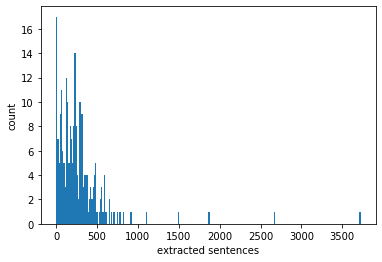

In [168]:
plt.hist(counts, bins=250)
plt.xlabel('extracted sentences')
plt.ylabel('count')

plt.show()

In [50]:
blw_100 = []
for i, count in enumerate(counts):
    if count < 30:
        blw_100.append(counts.index[i])

In [51]:
blw100_df = all_text[all_text.source.isin(blw_100)]

In [52]:
blw100_df.to_csv("test.csv", sep="\t")

In [24]:
counts.index

Index(['https://privacy.microsoft.com/en-us/privacystatement',
       'https://asana.com/terms#privacy-policy',
       'https://www.ebay.com/help/policies/member-behaviour-policies/user-privacy-notice-privacy-policy?id=4260',
       'https://www.bhphotovideo.com/find/HelpCenter/Policies.jsp#privacySecurity',
       'https://kb.newegg.com/knowledge-base/privacy-policy-newegg',
       'https://www.skillshare.com/privacy',
       'https://www.tenable.com/privacy-policy',
       'https://www.cnn.com/privacy0?no-st=9999999999',
       'https://wire.com/en/legal/#privacy',
       'https://www.dynadot.com/privacy_policy.html',
       ...
       'https://quad9.net/policy/', 'https://www.revolut.com/legal/privacy',
       'https://www.bestbuy.com/site/help-topics/privacy-policy/pcmcat204400050062.c?id=pcmcat204400050062',
       'https://www.hdtracks.com/#/privacy', 'https://openbazaar.org/privacy/',
       'https://www.notion.so/3468d120cf614d4c9014c09f6adc9091',
       'https://houseparty.com